## Imports

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import box
from rasterio.mask import mask
import contextily as ctx

## Data Directories

In [16]:
solar_file = "data/solar/ottawa_nsrdb_2020.csv"
landcover_file = "data/land/landcover-2020-classification.tif"
dem_file = "data/land/output_be.tif"
dem_slope_file = "data/land/viz/viz.be_slope.tif"
dem_aspect_file = "data/land/viz/viz.be_aspect.tif"
# No protected areas in Ottawa.
grid_lines_file = "data/Ottawa_grid_lines/ottawa_grid_lines.shp"
grid_substations_file = "data/Ottawa_grid_substations/ottawa_substations.shp"

## Solar Data

In [3]:
solar_data = pd.read_csv(solar_file, skiprows=2)
solar_data.head()

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,GHI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Global Horizontal UV Irradiance (280-400nm),Global Horizontal UV Irradiance (295-385nm)
0,2020,1,1,0,30,-0.8,0,0,0,4,...,0,98.82,120.70,0.87,990,0.8,201,0.7,0.0,0.0
1,2020,1,1,1,30,-1.5,0,0,0,4,...,0,98.48,131.20,0.87,990,0.8,207,0.6,0.0,0.0
2,2020,1,1,2,30,-2.2,0,0,0,4,...,0,97.80,141.35,0.87,990,0.8,208,0.6,0.0,0.0
3,2020,1,1,3,30,-2.8,0,0,0,4,...,0,97.12,150.34,0.87,989,0.8,210,0.6,0.0,0.0
4,2020,1,1,4,30,-3.2,0,0,0,4,...,0,95.72,156.48,0.87,989,0.8,221,0.6,0.0,0.0


In [4]:
solar_data['Timestamp'] = solar_data['Year'].astype(str) + '-' + solar_data['Month'].astype(str) + '-' + solar_data['Day'].astype(str) + ' ' + solar_data['Hour'].astype(str) + ':00'
solar_data.columns


Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point', 'DHI', 'DNI',
       'Fill Flag', 'GHI', 'Relative Humidity', 'Solar Zenith Angle',
       'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'Global Horizontal UV Irradiance (280-400nm)',
       'Global Horizontal UV Irradiance (295-385nm)', 'Timestamp'],
      dtype='object')

In [5]:
solar_data['Timestamp'] = pd.to_datetime(solar_data['Timestamp'], yearfirst=True)
solar_data = solar_data.set_index('Timestamp')
solar_data.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-12-31 14:00:00', '2020-12-31 15:00:00',
               '2020-12-31 16:00:00', '2020-12-31 17:00:00',
               '2020-12-31 18:00:00', '2020-12-31 19:00:00',
               '2020-12-31 20:00:00', '2020-12-31 21:00:00',
               '2020-12-31 22:00:00', '2020-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=8760, freq=None)

In [6]:
solar_data_6th_Month = solar_data[solar_data['Month']==6]
solar_data_6th_Month.index


DatetimeIndex(['2020-06-01 00:00:00', '2020-06-01 01:00:00',
               '2020-06-01 02:00:00', '2020-06-01 03:00:00',
               '2020-06-01 04:00:00', '2020-06-01 05:00:00',
               '2020-06-01 06:00:00', '2020-06-01 07:00:00',
               '2020-06-01 08:00:00', '2020-06-01 09:00:00',
               ...
               '2020-06-30 14:00:00', '2020-06-30 15:00:00',
               '2020-06-30 16:00:00', '2020-06-30 17:00:00',
               '2020-06-30 18:00:00', '2020-06-30 19:00:00',
               '2020-06-30 20:00:00', '2020-06-30 21:00:00',
               '2020-06-30 22:00:00', '2020-06-30 23:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=720, freq=None)

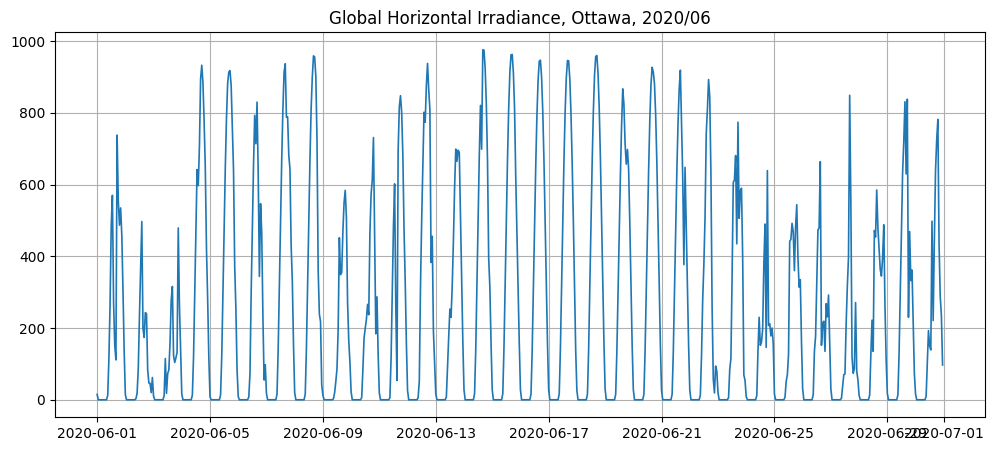

In [7]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(solar_data_6th_Month.index, solar_data_6th_Month.GHI, lw=1.2)
plt.grid(True)
ax.set_title("Global Horizontal Irradiance, Ottawa, 2020/06")
plt.show()

Raster CRS: EPSG:3979
Clipped land cover shape: (1, 3705, 4594)


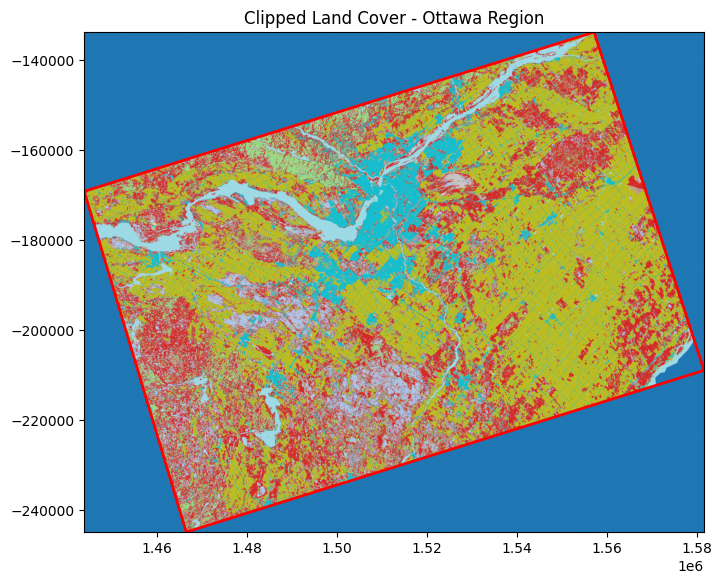

In [12]:
bbox = box(-76.5, 44.9, -75.0, 45.6) # min of lon & lat, max of lon & lat
geo = gpd.GeoDataFrame({"geometry":[bbox]}, crs="EPSG:4326")
land = "data/land/landcover-2020-classification.tif"
with rasterio.open(land) as src:
    print("Raster CRS:", src.crs)
    geo = geo.to_crs(src.crs)
    out_img, out_transform = mask(src, geo.geometry, crop=True)
    out_meta = src.meta

print("Clipped land cover shape:", out_img.shape)

fig, ax = plt.subplots(figsize=(8, 8))
show(out_img[0], transform=out_transform, ax=ax, cmap="tab20")
geo.boundary.plot(ax=ax, color="red", linewidth=2)  # overlay bbox outline
ax.set_title("Clipped Land Cover - Ottawa Region")
plt.show()

## Elevation

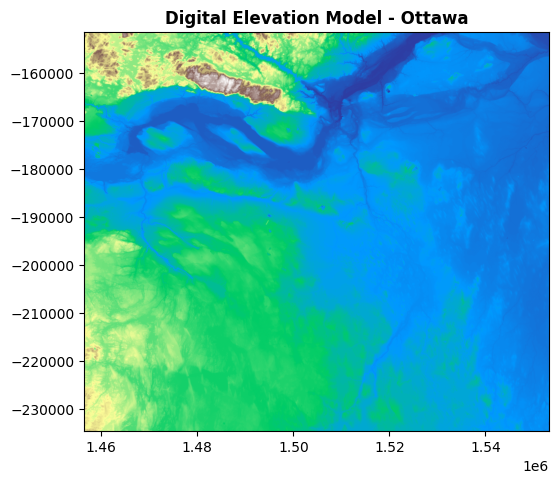

In [14]:
# Digital Elevation Model
with rasterio.open(dem_file) as src:
    fig, ax = plt.subplots(figsize=(6,6))
    show(src, ax=ax, title="Digital Elevation Model - Ottawa", cmap="terrain")

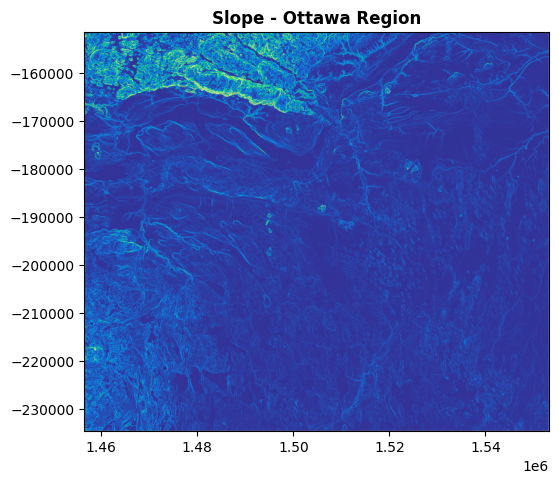

In [17]:
# Slope 
with rasterio.open(dem_slope_file) as src:
    fig, ax = plt.subplots(figsize=(6,6))
    show(src, ax=ax, title="Slope - Ottawa Region", cmap="terrain")

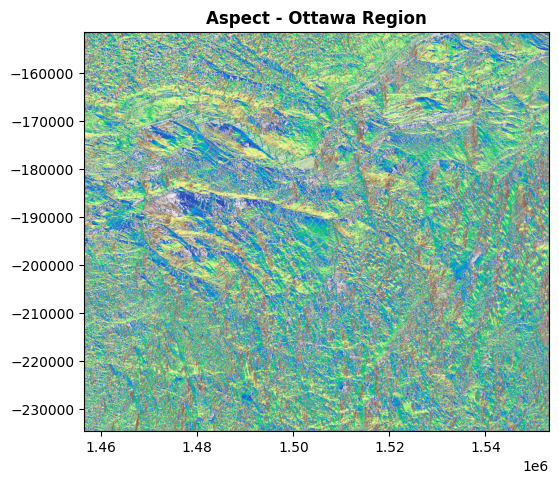

In [18]:
# Aspect
with rasterio.open(dem_aspect_file) as src:
    fig, ax = plt.subplots(figsize=(6,6))
    show(src, ax=ax, title="Aspect - Ottawa Region", cmap="terrain")

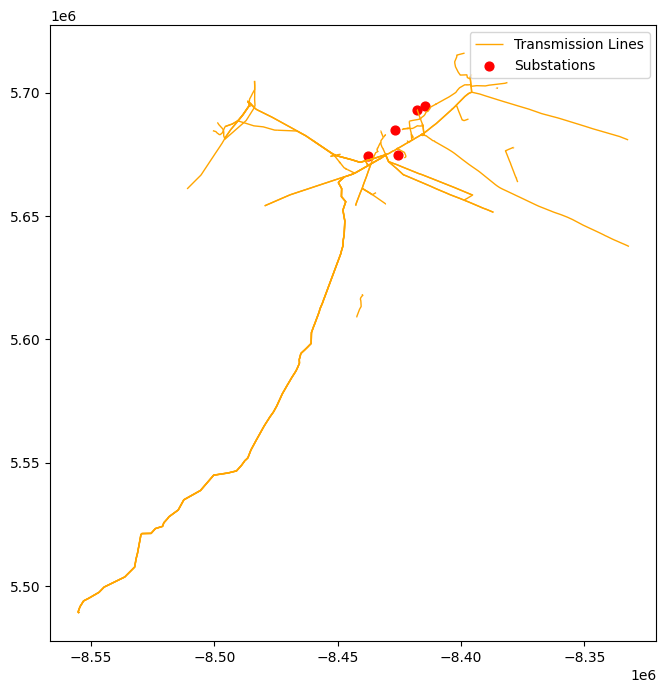

In [25]:
grid_lines = gpd.read_file(grid_lines_file).to_crs(epsg=3857)
grid_substations = gpd.read_file(grid_substations_file).to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(8,8))
grid_lines.plot(ax=ax, color="orange", linewidth=1, label="Transmission Lines")
grid_substations.plot(ax=ax, color="red", markersize=40, label="Substations")
ax.legend()
